In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import os
from sklearn.metrics import cohen_kappa_score

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [48]:
# load krillpodym and krillbase data formated
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/')

krill_base = pd.read_csv('./outputs_formated_data/Krill_density_krillbase_df_final.csv').rename(columns = {'LONGITUDE_largegrid' : 'longitude' , 'LATITUDE_largegrid' : 'latitude'})[['latitude', 'longitude', 'STANDARDISED_KRILL_UNDER_1M2_log']]
krill_podym = pd.read_csv('./outputs_formated_data/Krill_biomass_df_final.csv')[['latitude', 'longitude', 'krill_adult_log']]

In [49]:
krill_base = krill_base.dropna()#[krill_base['STANDARDISED_KRILL_UNDER_1M2_log'] != 0]
krill_base.set_index(['latitude', 'longitude'], inplace = True) # 1063  

krill_podym = krill_podym.dropna()[krill_podym['krill_adult_log'] != 0] # remove 0 bc Nan of krillbase are 0 of krillpodym
krill_podym.set_index(['latitude', 'longitude'], inplace = True) # 1648  

C:\Users\anael\AppData\Local\Temp\ipykernel_13828\3660438399.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  krill_podym = krill_podym.dropna()[krill_podym['krill_adult_log'] != 0] # remove 0 bc Nan of krillbase are 0 of krillpodym


# How are KRILLBASE data distributed over KRILLPODYM data

### extract the part of KRILLPODYM outputs where we have KRILLBASE data

Compaire the two over their common spatial range. 

In [50]:
krill_common_range = krill_base.merge(krill_podym, how='inner', left_index=True, right_index=True)
krill_common_range

,,STANDARDISED_KRILL_UNDER_1M2_log,krill_adult_log
latitude,longitude,,
-69,-179,0.000000,1.54654
-67,-179,0.000000,1.60825
-61,-179,1.355432,1.03334
-69,-177,0.000000,1.54440
-67,-177,0.000000,1.54895
...,...,...,...
-71,177,0.000000,1.44382
-67,177,1.645766,1.38528
-65,177,0.101403,1.35487


In [51]:
krill_podym_quantiles = krill_podym['krill_adult_log'].quantile(q=[0.3333, 0.6666])
krill_podym_quantiles_CR = krill_common_range['krill_adult_log'].quantile(q=[0.3333, 0.6666])

display(krill_podym_quantiles,
krill_podym_quantiles_CR)

0.3333    1.09418
0.6666    1.59819
Name: krill_adult_log, dtype: float64

0.3333    1.226229
0.6666    1.638561
Name: krill_adult_log, dtype: float64

The **krillpodym** tiertiles are higher over the common spatail range with KRILLBASE than when calculated on the whole krillpodym krill distribution.
> This means the KRILLBASE data are biaised, with sampling predominantly in regions with more krill.

> This also means the comparing the global upper tiertile of KRILLPODYM with upper tiertile of KRILLBASE and removing cells with disagreement will remove event more cells from the upper tiertile of krillpodym. (i.e., it is biaised to be stricter, above the initial issue caused by the different nb of avialable data points (cells))

# Validation/ comparison over their common spatial range

Compare and try to validate krillpodym data bu krillbase data over their shared space.

- correlation between the krill density by cell
- quantile comparision to check if patterns are the same (~ the finer quantile the srticter comparison)

# Correlation of the density per cell

In [52]:
t = krill_common_range[krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log']>0]
t

STANDARDISED_KRILL_UNDER_1M2_log  krill_adult_log
latitude longitude                                                   
-61      -179                               1.355432          1.03334
         -177                               1.355432          1.06386
-71      -175                               0.071022          1.50515
         -173                               0.071022          1.46315
         -171                               0.071022          1.31159
...                                              ...              ...
-65       173                               0.101403          1.40469
-67       175                               1.645766          1.38169
-65       175                               0.101403          1.48919
-67       177                               1.645766          1.38528
-65       177                               0.101403          1.35487

[734 rows x 2 columns]

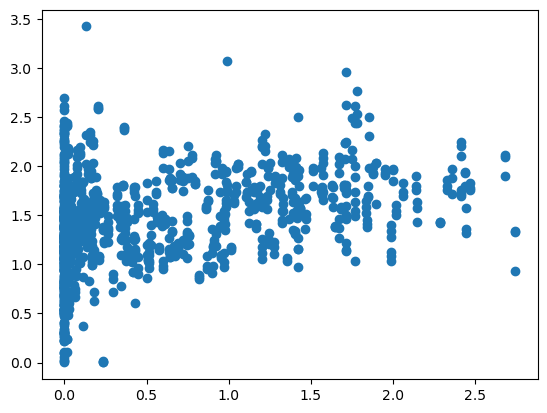

0.3750201400737513

In [53]:
plt.scatter(krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'], krill_common_range['krill_adult_log'])
plt.show()

correlation = krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'].corr(krill_common_range['krill_adult_log'])
correlation 

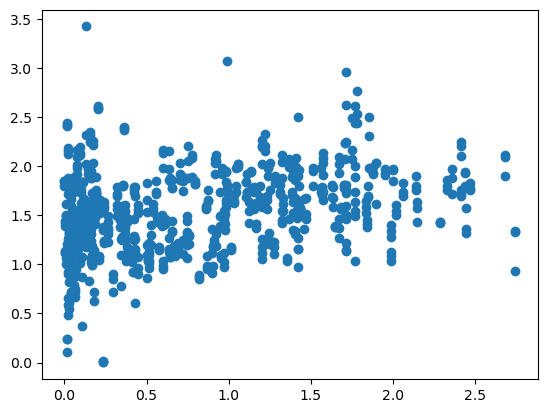

0.32848676972641644

In [54]:
plt.scatter(t['STANDARDISED_KRILL_UNDER_1M2_log'], t['krill_adult_log'])
plt.show()

correlation = t['STANDARDISED_KRILL_UNDER_1M2_log'].corr(t['krill_adult_log'])
correlation 

# Quantile comparision

### Tiertile

In [55]:
# tiertile
krill_common_range['quantile_KP'] = pd.qcut(krill_common_range['krill_adult_log'], q=3, labels=['low', 'medium', 'high'])
krill_common_range['quantile_KB'] = pd.qcut(krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'], q=3, labels=['low', 'medium', 'high'])

In [56]:
# confusion matrix
conf_matrix = pd.crosstab(krill_common_range['quantile_KB'], krill_common_range['quantile_KP'])
display(conf_matrix)

# concordance
diag = np.diag(conf_matrix.values).sum()
total = conf_matrix.values.sum()
concordance_ratio = diag / total
print(concordance_ratio)

# Kappa indice
kappa = cohen_kappa_score(krill_common_range['quantile_KB'], krill_common_range['quantile_KP'])
print(kappa)

# error rate 
error_rate = (krill_common_range['quantile_KP'] != krill_common_range['quantile_KB']).mean()
print(error_rate)

# proportion by category
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
display(conf_matrix_norm)

quantile_KP,low,medium,high
quantile_KB,,,
low,180,104,66
medium,122,142,87
high,48,103,196


0.2414115230496503
0.5057251908396947


quantile_KP,low,medium,high
quantile_KB,,,
low,0.514286,0.297143,0.188571
medium,0.347578,0.404558,0.247863
high,0.138329,0.296830,0.564841


In [57]:
## classif rate of the high krill density cells only
# right classif of "High": in cells classif as High in KB, how many are classifed as High in KP
true_positive_high = conf_matrix.loc['high', 'high']
total_pred_high = conf_matrix.loc['high'].sum()

accuracy_high = true_positive_high / total_pred_high
print(f"rate of good classif of 'high': {accuracy_high:.2%}")

# the oposite: in cells classif as High in KP, how many are classifed as High in KB
precision_high = conf_matrix.loc['high', 'high'] / conf_matrix['high'].sum()
print(f"Precision dof 'high' in KP : {precision_high:.2%}")

rate of good classif of 'high': 56.48%
Precision dof 'high' in KP : 56.16%


### Quartile

In [60]:
# tiertile
krill_common_range['quantile_KP_4'] = pd.qcut(krill_common_range['krill_adult_log'], q=4, labels=['low', 'medium_l', 'medium_h', 'high'])
krill_common_range['quantile_KB_4'] = pd.qcut(krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'], q=4, labels=['low', 'medium_l', 'medium_h', 'high'])

ValueError: Bin edges must be unique: array([0.        , 0.        , 0.18980623, 0.99746131, 2.74404042]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [59]:
# confusion matrix
conf_matrix = pd.crosstab(krill_common_range['quantile_KB'], krill_common_range['quantile_KP'])
display(conf_matrix)

# concordance
diag = np.diag(conf_matrix.values).sum()
total = conf_matrix.values.sum()
concordance_ratio = diag / total
concordance_ratio

# Kappa indice
kappa = cohen_kappa_score(krill_common_range['quantile_KB'], krill_common_range['quantile_KP'])
print(kappa)

# error rate 
error_rate = (krill_common_range['quantile_KP'] != krill_common_range['quantile_KB']).mean()
print(error_rate)

# proportion by category
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
display(conf_matrix_norm)

quantile_KP,low,medium_l,medium_h,high
quantile_KB,,,,
low,148,89,65,48
medium,87,108,92,64
high,27,65,105,150


0.14163090128755362


TypeError: Categoricals can only be compared if 'categories' are the same.

In [ ]:
## classif rate of the high krill density cells only
# right classif of "High": in cells classif as High in KB, how many are classifed as High in KP
true_positive_high = conf_matrix.loc['high', 'high']
total_pred_high = conf_matrix.loc['high'].sum()

accuracy_high = true_positive_high / total_pred_high
print(f"rate of good classif of 'high': {accuracy_high:.2%}")

# the oposite: in cells classif as High in KP, how many are classifed as High in KB
precision_high = conf_matrix.loc['high', 'high'] / conf_matrix['high'].sum()
print(f"Precision dof 'high' in KP : {precision_high:.2%}")